In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import  silhouette_score
import lib.utils_clustering as util
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Clustering with additional stats
Preprocessing: 
- exclude visits with 3 or less page views
- calculate z-score for 'npageViews', 'nproducts', 'timeSpent', 'nsearches', 'avgLeadSum' and remove outliers with a threshold of 4 sds
- scale numerical columns (Standardize: mean 0 and sd 1)
- perform PCA with 6 components 
- perform clustering with unfiltered data
- exclude visits with no recorded time spent on the page
- perform clustering

Clustering:
- Initialize cluster centroids using k-means++
- parameters: k = 1-10; batch_size 100000; max_iter = 100; n_jobs -1
- Perform mini batch kmeans for different k values and measure sse, silhouette score (for a sample size of 100000) and calinski_harabasz_score and plot values
- Test for differences using ANOVA
- Train different ML classifiers to predict clusters

In [23]:
visit_statistics = pd.read_csv("./data/visit_statistics.csv", sep=';')
#remove sessions with no page views
visit_statistics = visit_statistics.loc[visit_statistics['npageViews'] > 0]
visit_statistics.set_index('idVisit', inplace=True)

In [24]:
#define parameters for k-means
parameters = {
    'init': "k-means++",
    'n_clusters_range': range(1, 11),
    'batch_size': 100000,
    'max_iter': 100,
    'n_jobs': -1,
    'random_state': 1337,
    'silhouette_sample_size': 100000
}

In [25]:
#apply filtering for short sessions and remove outliers with Z > 4
visit_statistics = visit_statistics.loc[visit_statistics['timeSpent'] > 0]
visit_statistics = visit_statistics.loc[visit_statistics['npageViews'] > 3]
scaled_stats, filtered_df = util.preprocess_data_z_score(visit_statistics, 4)

In [26]:
#referrer and visitor type proportions for the whole sample
print(visit_statistics['referrerType'].value_counts(normalize=True))
#new users have no previous recorded sessions, returning users have at least on recorded session and returningCustomer have at least one recorded session with a lead
print(visit_statistics['visitorType'].value_counts(normalize=True))

referrerType
direct     0.623
search     0.329
campaign   0.040
website    0.008
social     0.000
Name: proportion, dtype: float64
visitorType
returningCustomer   0.364
returning           0.353
new                 0.283
Name: proportion, dtype: float64


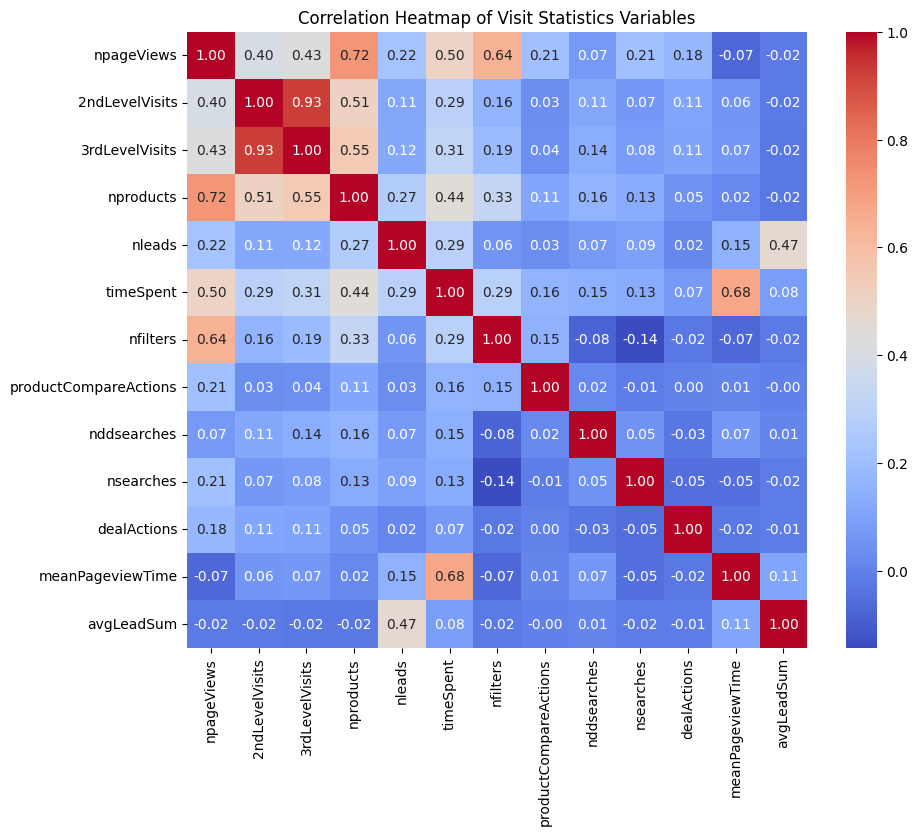

In [28]:
#calculate correlation matrix and plot as heatmap
util.plot_corr_heatmap(filtered_df)

In [29]:
#apply PCA to reduce dimensionality
scaled_stats = util.apply_PCA(scaled_stats, 6)

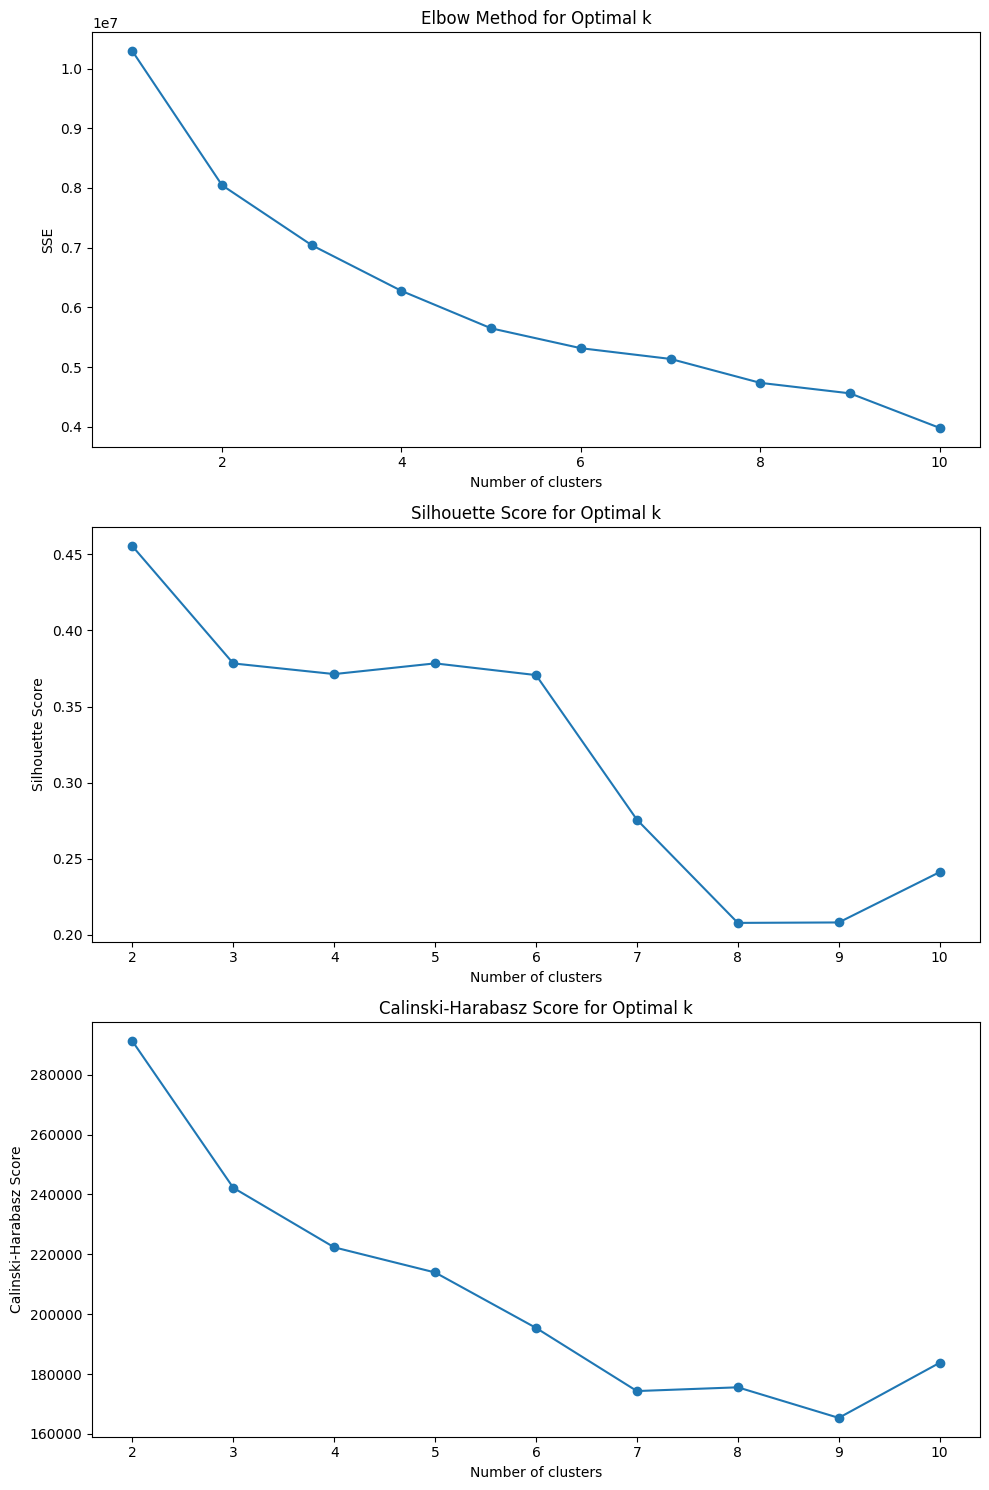

In [30]:
#calculate scores to find the optimal number of clusters
silhouettes = util.find_opt_k(scaled_stats, parameters)

In [31]:
#apply clustering to generate 6 clusters
cluster_labels, cluster_centers, inertia, filtered_df = util.perform_clustering(scaled_stats, filtered_df, parameters,6)
filtered_df['cluster'] = cluster_labels

In [32]:
#calculate silhouette score for the whole sample
print(silhouette_score(scaled_stats, cluster_labels))

0.37070002243185407


In [33]:
label_counts = np.bincount(cluster_labels)

# Print the relative value counts for each cluster
for cluster_id, count in enumerate(label_counts):
    relative_count = count / label_counts.sum()
    print(f"Cluster {cluster_id}: {relative_count:.2%} of data points")


Cluster 0: 63.70% of data points
Cluster 1: 7.66% of data points
Cluster 2: 8.76% of data points
Cluster 3: 8.89% of data points
Cluster 4: 8.53% of data points
Cluster 5: 2.46% of data points


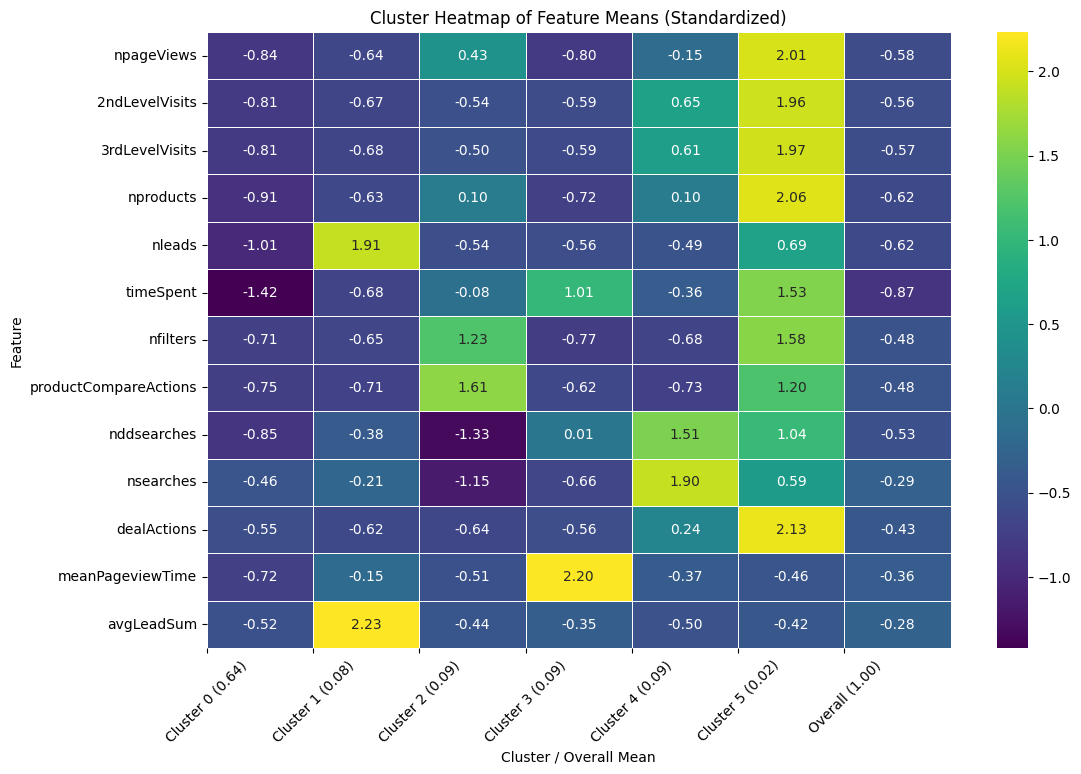

In [34]:
util.cluster_means_heatmap(filtered_df)

In [35]:
merged_df = visit_statistics.merge(filtered_df[['cluster']], left_index=True, right_index=True, how='inner')

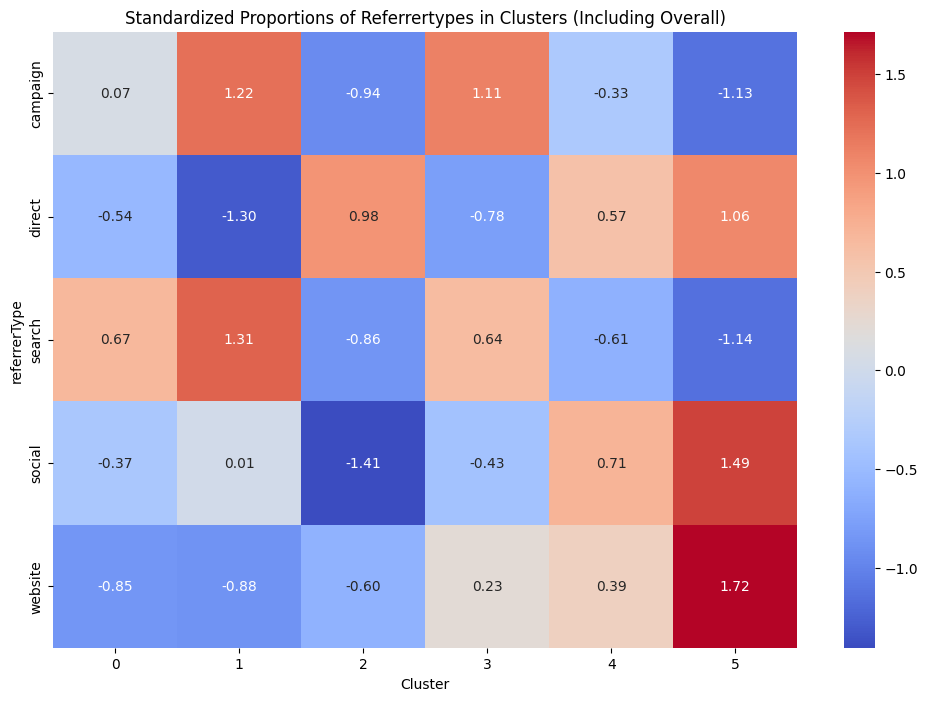

In [36]:
#standardized proportions of referrer types of sessions in each cluster
util.plot_standardized_proportions(merged_df, 'referrerType')

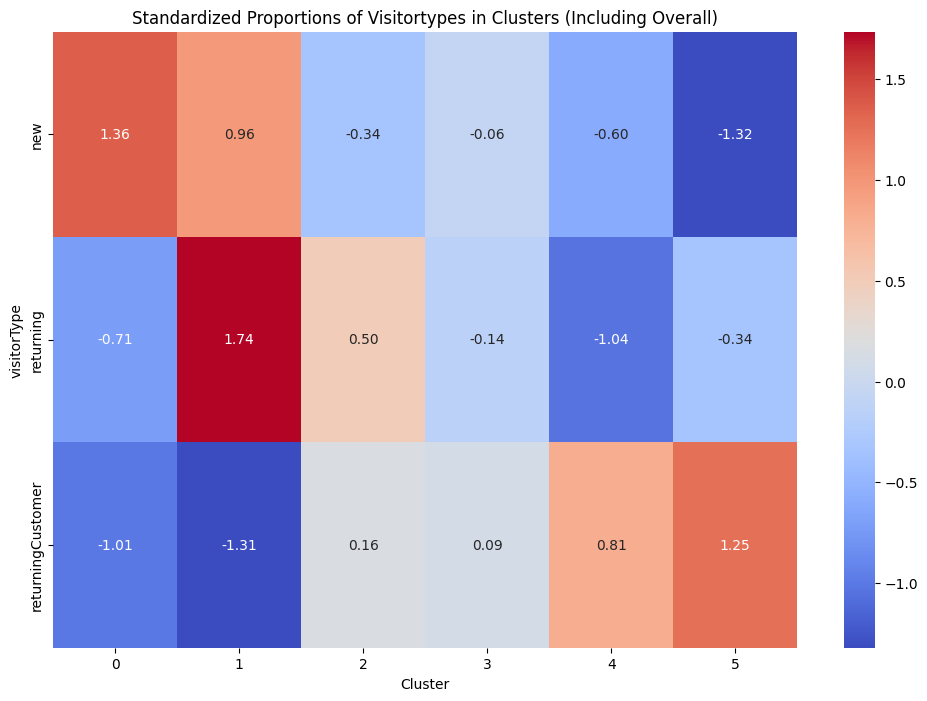

In [37]:
util.plot_standardized_proportions(merged_df, 'visitorType')

In [38]:
util.perform_ANOVA(merged_df)

Feature                | F-Statistic          | p-value 
--------------------------------------------------
npageViews             |           383,454.01 | 0.000
2ndLevelVisits         |           173,970.79 | 0.000
3rdLevelVisits         |           197,245.69 | 0.000
nproducts              |           210,376.34 | 0.000
nleads                 |           101,169.13 | 0.000
timeSpent              |           239,336.08 | 0.000
nfilters               |           185,319.36 | 0.000
productCompareActions  |            16,024.41 | 0.000
nddsearches            |            10,330.84 | 0.000
nsearches              |            21,896.86 | 0.000
dealActions            |             7,874.39 | 0.000
meanPageviewTime       |           325,516.21 | 0.000
avgLeadSum             |           254,076.60 | 0.000


In [39]:
merged_df_reset = merged_df.reset_index()
merged_df.to_csv('./data/cluster_results.csv', sep=";", index=True)

In [43]:
util.evaluate_classifiers(scaled_stats, cluster_labels, parameters)
